In [1]:
import numpy as np
import pandas as pd
import sqlalchemy
import os
import math
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use('ggplot')
plt.figure(figsize=(12,8), dpi= 100)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100


<Figure size 1200x800 with 0 Axes>

In [2]:
# get the crypto data
data_dir = "../data/coin_data/"
exclude = {'markets.csv', 'maker.csv'}
coin_start_date = datetime.strptime("2015-12-01","%Y-%m-%d").date()
datasets = [str(f) for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)) and str(f) not in exclude]
coin_dfs = {dataset[:-4] : pd.read_csv(data_dir+dataset, index_col=2)  for dataset in datasets}

def merge_dfs(dfs, return_col, rolling_mean=False): 
    """
    merge return cols of dfs based on index column. take rolling
    mean of 7 days and return the resulting df
    """
    merged_df = None
    for name, df in dfs.items():
        df = df.rename(columns={f"{return_col}": name})[[name]]
        merged_df = (
            df if merged_df is None
            else pd.merge(merged_df, df, left_index=True, right_index=True, how="inner")
        )
    if rolling_mean:
        merged_df = merged_df.rolling(7, min_periods=1).mean()
    return merged_df


print("coin name\tdata start")
for k in list(coin_dfs.keys()):
    df = coin_dfs[k]
    try: 
        x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S.%f").date() for d in df.index]
    except ValueError:
        x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in df.index]
    df.index = x_values
    if min(x_values) > coin_start_date or k in exclude:
        del coin_dfs[k]
    else:
        print(k, min(x_values), sep="\t")
    df.drop(columns=['timestamp'], inplace=True)

    
asset_prices_df = merge_dfs(coin_dfs, 'price', rolling_mean=True)
# get the spy data
spy_df = yf.download('SPY', start='1993-02-01', end='2021-12-01')
spy_df.tail()

coin name	data start
monero	2014-05-21
dogecoin	2013-12-15
stellar	2014-08-06
tether	2015-02-25
ripple	2013-08-04
ethereum	2015-08-07
litecoin	2013-04-28
bitcoin	2013-04-28
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-23,467.220001,469.100006,464.450012,468.190002,468.190002,73206500
2021-11-24,466.059998,469.570007,465.190002,469.440002,469.440002,61858800
2021-11-26,462.339996,463.899994,457.769989,458.970001,458.970001,112669600
2021-11-29,464.070007,466.559998,461.730011,464.600006,464.600006,86268800
2021-11-30,462.000000,464.029999,455.299988,455.559998,455.559998,148559600


# Bull Market and Bear Market
## Stock Market
**Bear Market**: When a broad market index (S&P 500) falls by at least 20% in a two month period. [(source)](https://www.investor.gov/introduction-investing/investing-basics/glossary/bear-market)

**Bull Market**: When a broad market index (S&P 500) rises by at least 20% in a two month period followed by a bear market.


**Where does this 20% come from?**

In [18]:
def volatility(prices, duration):
    log_returns = np.log(prices / prices.shift(1))
    return np.sqrt(duration) * np.std(log_returns)   

def roi(prices, duration):
    log_returns = np.log(prices / prices.shift(1))
    return np.exp(np.mean(log_returns)*duration) - 1

period = 365*3
period_spy = 252*6

spy_vol = volatility(spy_df.Close[-252*20:], 252)
spy_roi = roi(spy_df.Close[-252*20:], 252)
print({"annual_vol": spy_vol, "annual_roi":spy_roi})

{'annual_vol': 0.19316388813870317, 'annual_roi': 0.07095265502163617}


In [4]:
btc_vol = volatility(asset_prices_df.bitcoin[-period:], 365)
btc_roi = roi(asset_prices_df.bitcoin[-period:], 365)
print({"annual_vol": btc_vol, "annual_roi":btc_roi})

{'annual_vol': 0.2943736013555757, 'annual_roi': 1.2718549190646464}


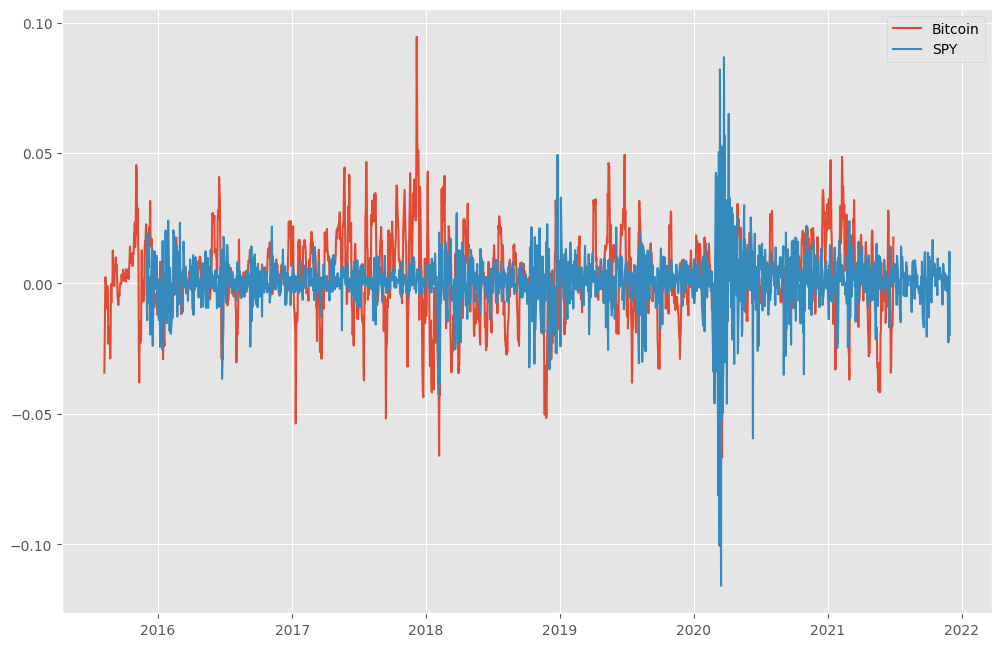

In [5]:
y_btc = np.log(asset_prices_df.bitcoin / asset_prices_df.bitcoin.shift(1))[-period:]
y_spy = spy_df.Close[-period_spy:]
y_spy = np.log(y_spy / y_spy.shift(1))
plt.plot(asset_prices_df.index[-period:], y_btc, label="Bitcoin")
plt.plot(spy_df.index[-period_spy:], y_spy, label="SPY")
plt.legend()
plt.show()

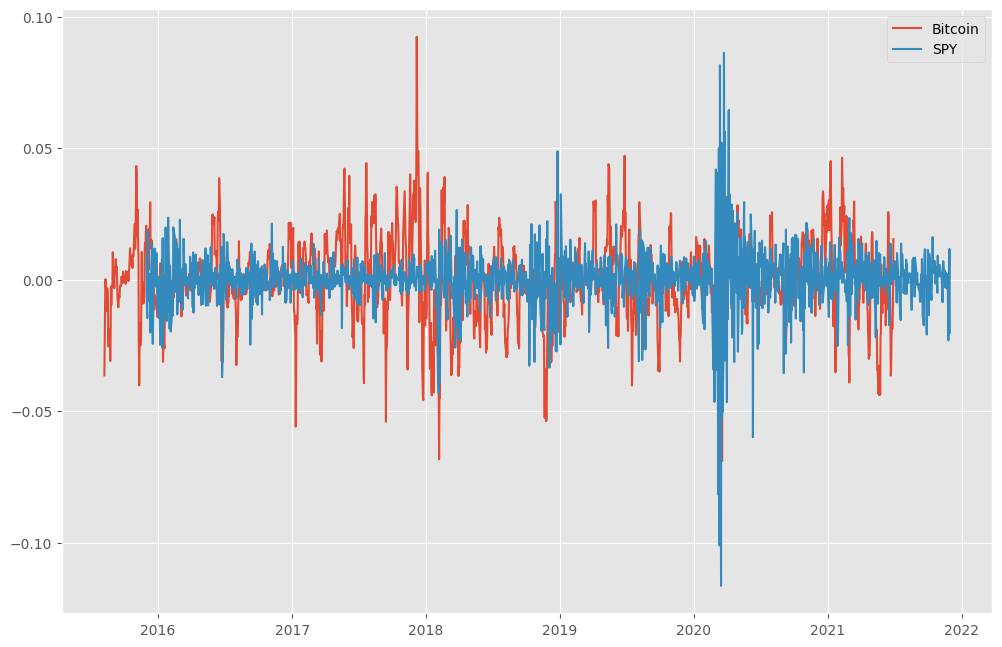

In [6]:
y_btc_white = y_btc - np.mean(y_btc)
y_spy_white = y_spy - np.mean(y_spy)

btc_price_white = np.exp(y_btc_white.cumsum())
spy_price_white = np.exp(y_spy_white.cumsum())

plt.plot(asset_prices_df.index[-period:], y_btc_white, label="Bitcoin")
plt.plot(spy_df.index[-period_spy:], y_spy_white, label="SPY")
plt.legend()
plt.show()

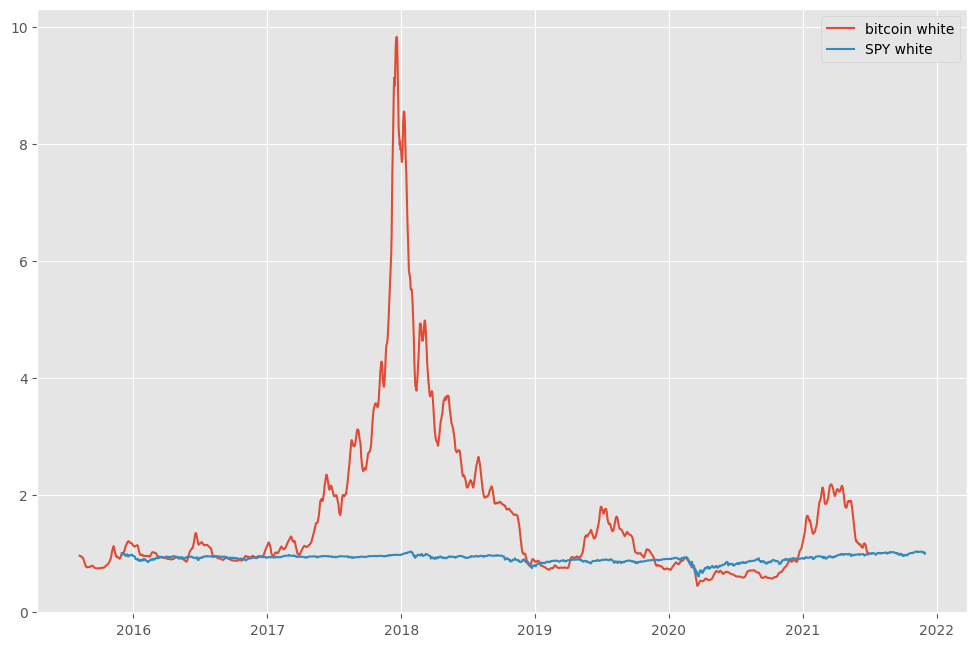

In [7]:
plt.plot(asset_prices_df.index[-period:], btc_price_white, label="bitcoin white")
plt.plot(spy_df.index[-period_spy:], spy_price_white, label="SPY white")
plt.legend()

In [8]:
np.abs(y_btc_white - y_spy_white).mean()

0.013736192049814964

{'spy white std': 0.01146888129801945}
{'btc white std': 0.015408218512854331}


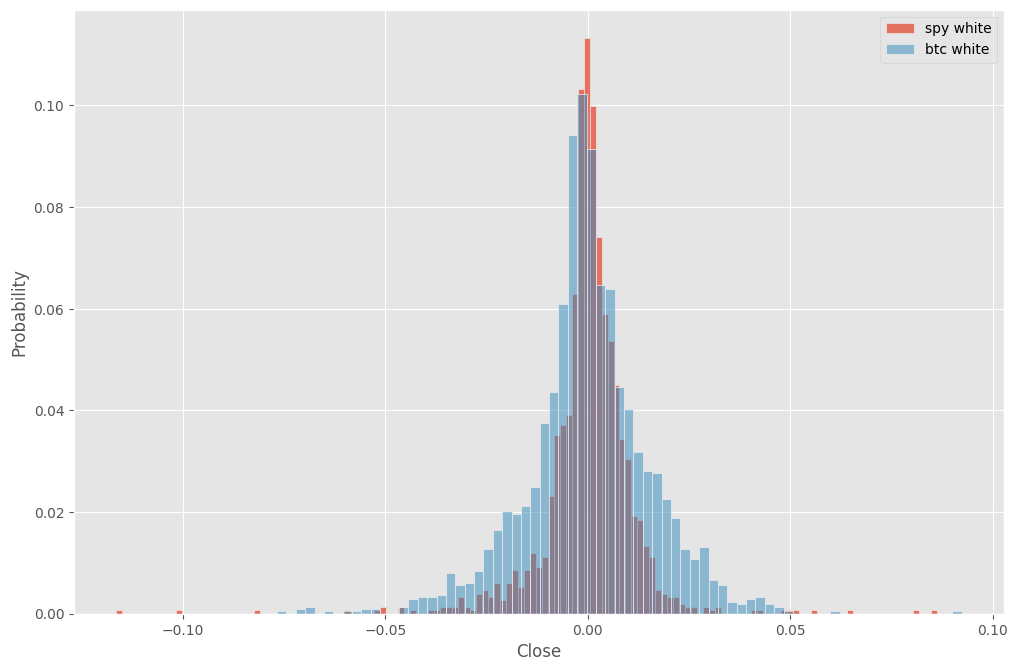

In [9]:
print({"spy white std" : np.std(y_spy_white)})
print({"btc white std" : np.std(y_btc_white)})

sns.histplot(y_spy_white, stat="probability", kde=False, color="C0", label="spy white")
sns.histplot(y_btc_white, stat="probability", kde=False, color="C1", label="btc white", alpha=0.5)
plt.legend()
plt.show()


In [10]:
print(asset_prices_df.bitcoin[:5])
print(asset_prices_df.bitcoin.shift(-1)[:5])

2015-08-07    278.508814
2015-08-08    269.154771
2015-08-10    267.295914
2015-08-11    267.938636
2015-08-12    267.893428
Name: bitcoin, dtype: float64
2015-08-07    269.154771
2015-08-08    267.295914
2015-08-10    267.938636
2015-08-11    267.893428
2015-08-12    267.187160
Name: bitcoin, dtype: float64


## ETF Strategies
### Inverse volatility

In [24]:
print(asset_prices_df.columns)
if "tether" in asset_prices_df.columns:
    del asset_prices_df["tether"]

def update_asset_alloc(asset_prices_df, index):
    asset_alloc = {asset_name : 1/volatility(asset_prices_df[asset_name][:index], 30) 
               for asset_name in asset_prices_df.columns}
    # normalize
    asset_alloc = {asset_name : alloc/sum(asset_alloc.values()) 
                   for asset_name, alloc in asset_alloc.items()}
    return asset_alloc

Index(['monero', 'dogecoin', 'stellar', 'ripple', 'ethereum', 'litecoin',
       'bitcoin'],
      dtype='object')


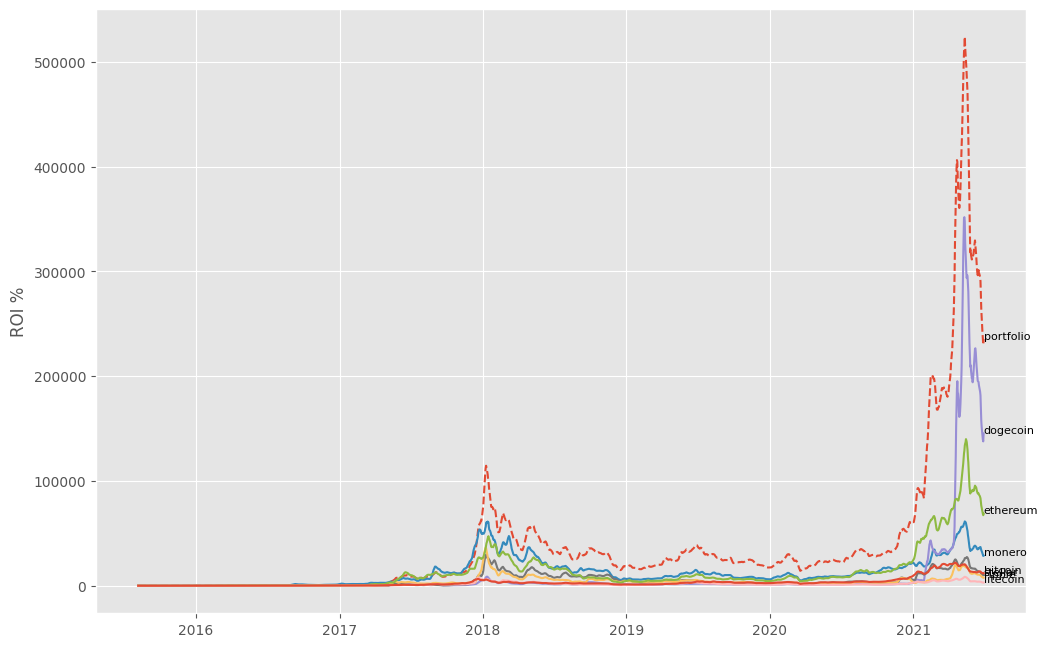

In [33]:
def generate_roi(asset_weights, assets_df, plot=True, rebalance_period=1):
    """
    given the asset weights, generate the return on $100 initial investment
    rebalances on the first day of each rebalance_period
    """
    investment_total = 100
    asset_allocation = {
        asset: investment_total * weight for asset, weight in asset_weights.items()
    }
    investment_daily_value = [investment_total]
    for i in range(len(assets_df) - 1):
        for asset, weight in asset_weights.items():
            asset_price_today = assets_df[asset][i]
            asset_price_next_day = assets_df[asset][i + 1]
            asset_allocation[asset] *= asset_price_next_day / asset_price_today
        investment_total = sum(asset_allocation.values())
        investment_daily_value.append(investment_total)
        if rebalance_period is not None and rebalance_period > 0 and i % rebalance_period == 0 and i > 0:
#             asset_weights = update_asset_alloc(asset_prices_df, i)
            asset_allocation = {
                asset: investment_total * weight for asset, weight in asset_weights.items()
            }

    roi = [dv - 100 for dv in investment_daily_value]
    if plot:
        plt.plot(assets_df.index, roi, "--", label="portfolio")
        plt.annotate(text="portfolio", xy=(assets_df.index[-1], roi[-1]), fontsize=8)
        for asset in assets_df.columns:
            roi_asset = (assets_df[asset] / assets_df[asset][0]) * 100 - 100
            x, y = assets_df.index, roi_asset
            plt.plot(x, y, label=asset)
            plt.annotate(text=asset, xy=(x[-1], y[-1]), fontsize=8)
            plt.ylabel("ROI %")
    #             plt.legend()
    return roi

asset_alloc = {asset_name : 1/len(asset_prices_df.columns) for asset_name in asset_prices_df.columns}
_ = generate_roi(asset_alloc, asset_prices_df, plot=True, rebalance_period=30)